In [120]:
import pandas as pd
# Download https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data and unzip in the archive folder
# Load the mass case description CSV
mass_train = pd.read_csv("archive/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("archive/csv/mass_case_description_test_set.csv")

# Concatenate train and test for a full dataset 
mass_df = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)

# Select relevant columns likely to contribute to the classification
selected_columns = [
    'image file path',      # For image loading
    'pathology',            # Label
    'breast_density',       # Numeric
    'left or right breast', # Categorical
    'subtlety',             # Numeric
    'mass margins'          # Categorical
]
mass_df = mass_df[selected_columns]

print(mass_df.head())

                                     image file path  pathology  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  MALIGNANT   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  MALIGNANT   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...     BENIGN   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...     BENIGN   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...     BENIGN   

   breast_density left or right breast  subtlety   mass margins  
0               3                 LEFT         4     SPICULATED  
1               3                 LEFT         4     SPICULATED  
2               3                 LEFT         3    ILL_DEFINED  
3               3                 LEFT         3    ILL_DEFINED  
4               3                RIGHT         5  CIRCUMSCRIBED  


In [121]:
# Drop rows with missing image paths or labels
mass_df = mass_df.dropna(subset=['image file path', 'pathology'])

# Optionally, drop rows with missing tabular features (or impute as needed)
mass_df = mass_df.dropna(subset=['breast_density', 'left or right breast', 'subtlety', 'mass margins'])

print(f"Remaining samples: {len(mass_df)}")

Remaining samples: 1636


In [122]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# One-hot encode 'left or right breast' and 'mass margins'
categorical_features = mass_df[['left or right breast', 'mass margins']]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(categorical_features)

# Numeric features
numeric_features = mass_df[['breast_density', 'subtlety']].values

# Ensure both are 2D arrays
print("numeric_features shape:", numeric_features.shape)
print("categorical_encoded shape:", categorical_encoded.shape)

# Combine all tabular features
tabular_features = np.hstack([numeric_features, categorical_encoded])

print("Tabular features shape:", tabular_features.shape)

numeric_features shape: (1636, 2)
categorical_encoded shape: (1636, 21)
Tabular features shape: (1636, 23)


In [123]:
# Get image paths as a list
image_paths = mass_df['image file path'].tolist()

# Map pathology to binary label
label_map = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
labels = mass_df['pathology'].map(label_map).values

print("Number of images:", len(image_paths))
print("Number of labels:", len(labels))

Number of images: 1636
Number of labels: 1636


In [124]:
# Create DICOM to JPEG mapping using dicom_info.csv 
print("Creating DICOM to JPEG mapping using dicom_info.csv...")

# Load the dicom_info.csv file which contains the actual DICOM→JPEG mapping
dicom_info = pd.read_csv("archive/csv/dicom_info.csv")
print(f"Loaded dicom_info.csv with {len(dicom_info)} entries")

# Print column info for debugging
print("Available columns in dicom_info.csv:")
print(dicom_info.columns.tolist())

# Let's look at the first few rows to understand the structure
print("\nFirst few rows of dicom_info.csv:")
print(dicom_info.head(2))

# file_path: CBIS-DDSM/dicom/[UID]/[filename].dcm
# image_path: CBIS-DDSM/jpeg/[UID]/[filename].jpg

# Create a mapping dictionary from DICOM UIDs to JPEG paths
uid_to_jpeg_map = {}

for idx, row in dicom_info.iterrows():
    dicom_path = row['file_path']  # DICOM path
    jpeg_path = row['image_path']  # JPEG path
    
    # Skip if either path is not a string or empty
    if not isinstance(dicom_path, str) or not isinstance(jpeg_path, str):
        continue
    if not dicom_path or not jpeg_path:
        continue
        
    # Extract UID from DICOM path
    # Format: CBIS-DDSM/dicom/[UID]/[filename].dcm
    dicom_parts = dicom_path.split('/')
    if len(dicom_parts) >= 3 and 'dicom' in dicom_path:
        uid = dicom_parts[2]  # The UID is the third part (after CBIS-DDSM/dicom/)
        
        # Convert JPEG path to local archive path
        local_jpeg_path = jpeg_path.replace("CBIS-DDSM/jpeg/", "archive/jpeg/")
        uid_to_jpeg_map[uid] = local_jpeg_path

print(f"Created UID mapping for {len(uid_to_jpeg_map)} UIDs")

# Let's also check a few sample UIDs to see if they look correct
print("\nSample UID mappings:")
sample_uids = list(uid_to_jpeg_map.keys())[:3]
for uid in sample_uids:
    print(f"UID: {uid}")
    print(f"JPEG: {uid_to_jpeg_map[uid]}")
    print(f"Exists: {os.path.exists(uid_to_jpeg_map[uid])}")
    print("-" * 40)

# Now map our mass case description DICOM paths to JPEG paths
jpeg_image_paths = []
successful_mappings = 0

print("\nMapping mass case paths to JPEG paths...")
print("Sample mass path analysis:")
sample_path = image_paths[0]
print(f"Sample path: {sample_path}")
sample_parts = sample_path.split('/')
print(f"Path parts: {sample_parts}")
if len(sample_parts) >= 3:
    print(f"UID1 (part 1): {sample_parts[1]}")
    print(f"UID2 (part 2): {sample_parts[2]}")
print("-" * 50)

for i, mass_dicom_path in enumerate(image_paths):
    found_jpeg = None
    
    # Extract UIDs from mass case description path
    # Format: "Mass-Training_P_00001_LEFT_CC/[UID1]/[UID2]/000000.dcm"
    mass_parts = mass_dicom_path.split('/')
    
    # Try both UIDs from the mass case description path
    uids_to_try = []
    if len(mass_parts) >= 2:
        uids_to_try.append(mass_parts[1])  # First UID
    if len(mass_parts) >= 3:
        uids_to_try.append(mass_parts[2])  # Second UID
    
    # Try to find a match for either UID
    for uid in uids_to_try:
        if uid in uid_to_jpeg_map:
            found_jpeg = uid_to_jpeg_map[uid]
            successful_mappings += 1
            break  # Found a match, stop trying
    
    jpeg_image_paths.append(found_jpeg)

print(f"Successfully mapped {successful_mappings} out of {len(image_paths)} DICOM paths to JPEG files")

# Show some example mappings
print("\nExample mappings:")
for i in range(min(5, len(image_paths))):
    print(f"Mass DICOM: {image_paths[i]}")
    print(f"Mapped JPEG: {jpeg_image_paths[i]}")
    if jpeg_image_paths[i]:
        print(f"Exists: {os.path.exists(jpeg_image_paths[i])}")
    print("-" * 80)


Creating DICOM to JPEG mapping using dicom_info.csv...
Loaded dicom_info.csv with 10237 entries
Available columns in dicom_info.csv:
['file_path', 'image_path', 'AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate', 'ContentTime', 'ConversionType', 'HighBit', 'InstanceNumber', 'LargestImagePixelValue', 'Laterality', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex', 'PhotometricInterpretation', 'PixelRepresentation', 'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SecondaryCaptureDeviceManufacturer', 'SecondaryCaptureDeviceManufacturerModelName', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SmallestImagePixelValue', 'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime']

First few rows of dicom_info.csv:
                                           file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-D

In [125]:
# Check that everything is aligned and verify the mapping worked
print("Checking final data alignment:")
for i in range(min(3, len(image_paths))):
    print(f"Original DICOM: {image_paths[i]}")
    print(f"Mapped JPEG: {jpeg_image_paths[i]}")
    if jpeg_image_paths[i]:
        print(f"Path exists: {os.path.exists(jpeg_image_paths[i])}")
    print(f"Tabular: {tabular_features[i]}")
    print(f"Label: {labels[i]}")
    print("-" * 20)

Checking final data alignment:
Original DICOM: Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm
Mapped JPEG: archive/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
Path exists: True
Tabular: [3. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 1
--------------------
Original DICOM: Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm
Mapped JPEG: archive/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
Path exists: True
Tabular: [3. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 1
--------------------
Original DICOM: Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.

In [126]:
import numpy as np
import cv2
from PIL import Image
import os

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess image from either DICOM or JPEG format
    """
    try:
        # Check if path exists
        if not os.path.exists(image_path):
            print(f"Warning: Image not found at {image_path}")
            return None
            
        # If DICOM file
        if image_path.lower().endswith('.dcm'):
            import pydicom
            dicom = pydicom.dcmread(image_path)
            image = dicom.pixel_array
            # Convert grayscale to 3-channel
            if len(image.shape) == 2:
                image = np.stack([image]*3, axis=-1)
            # Normalize to [0, 255]
            image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255.0
            image = image.astype(np.uint8)
        else:
            # For JPEG/PNG files
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not read image: {image_path}")
                return None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        image = cv2.resize(image, target_size)
        # Normalize to [0, 1]
        image = image / 255.0
        return image.astype(np.float32)
    
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return None

In [127]:
# Load images with error handling
loaded_images = []
valid_indices = []

print("Loading images...")
for i, path in enumerate(jpeg_image_paths):
    # Skip if no mapping was found
    if path is None:
        continue
        
    image = load_and_preprocess_image(path)
    if image is not None:
        loaded_images.append(image)
        valid_indices.append(i)
    
    if i % 100 == 0:  # Progress indicator
        print(f"Processed {i}/{len(jpeg_image_paths)} images")

print(f"Successfully loaded {len(loaded_images)} out of {len(jpeg_image_paths)} images")

# Filter tabular data and labels to match successfully loaded images
if loaded_images:
    X_images = np.array(loaded_images)
    X_tabular = tabular_features[valid_indices].astype(np.float32)
    y = labels[valid_indices].astype(np.int32)
    
    print("SUCCESS: Images loaded successfully!")
    print("Final array shapes:")
    print("Image array shape:", X_images.shape)
    print("Tabular array shape:", X_tabular.shape)
    print("Labels shape:", y.shape)
    
    # Show class distribution
    unique, counts = np.unique(y, return_counts=True)
    print("Class distribution:")
    for label, count in zip(unique, counts):
        print(f"  Class {label}: {count} samples")
else:
    print("ERROR: No images were successfully loaded!")
    print("This might mean:")
    print("1. The JPEG files don't exist in the expected locations")
    print("2. The UID mapping between DICOM and JPEG paths is incorrect")
    print("3. There's an issue with the file format or permissions")
    X_images = np.empty((0, 224, 224, 3))
    X_tabular = tabular_features.astype(np.float32)
    y = labels.astype(np.int32)

Loading images...
Processed 0/1636 images
Processed 100/1636 images
Processed 200/1636 images
Processed 300/1636 images
Processed 400/1636 images
Processed 500/1636 images
Processed 600/1636 images
Processed 700/1636 images
Processed 800/1636 images
Processed 900/1636 images
Processed 1000/1636 images
Processed 1100/1636 images
Processed 1200/1636 images
Processed 1300/1636 images
Processed 1400/1636 images
Processed 1500/1636 images
Processed 1600/1636 images
Successfully loaded 1636 out of 1636 images
SUCCESS: Images loaded successfully!
Final array shapes:
Image array shape: (1636, 224, 224, 3)
Tabular array shape: (1636, 23)
Labels shape: (1636,)
Class distribution:
  Class 0: 863 samples
  Class 1: 773 samples


In [128]:
from sklearn.model_selection import train_test_split

# Only proceed with train/test split if we have images
if len(X_images) > 0:
    X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
        X_images, X_tabular, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train set - Images: {X_img_train.shape}, Tabular: {X_tab_train.shape}, Labels: {y_train.shape}")
    print(f"Test set - Images: {X_img_test.shape}, Tabular: {X_tab_test.shape}, Labels: {y_test.shape}")
else:
    print("ERROR: Cannot split data - no images were loaded successfully!")
    print("Please check your image paths and ensure the JPEG files exist.")

Train set - Images: (1308, 224, 224, 3), Tabular: (1308, 23), Labels: (1308,)
Test set - Images: (328, 224, 224, 3), Tabular: (328, 23), Labels: (328,)


In [131]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Image branch
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
x = GlobalAveragePooling2D()(base_model.output)

# Tabular branch
tabular_input = Input(shape=(X_tabular.shape[1],), name='tabular_input')
y = Dense(64, activation='relu')(tabular_input)
y = Dropout(0.3)(y)
y = Dense(32, activation='relu')(y)

# Combine
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)  # Binary classification

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,724,577 (90.50 MB)

 Trainable params: 23,671,457 (90.30 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [132]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_test, X_tab_test], y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.5581 - loss: 0.8180 - val_accuracy: 0.5274 - val_loss: 0.6889
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5357 - loss: 0.6910 - val_accuracy: 0.5274 - val_loss: 0.6833
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.5709 - loss: 0.6801 - val_accuracy: 0.5274 - val_loss: 0.6661
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6430 - loss: 0.6259 - val_accuracy: 0.7957 - val_loss: 0.4880
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7236 - loss: 0.5755 - val_accuracy: 0.8079 - val_loss: 0.4608
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7229 - loss: 0.5369 - val_accuracy: 0.8049 - val_loss: 0.4519
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7770 - loss: 0.5025 - val_accuracy: 0.7988 - val_loss: 0.4404
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7629 - loss: 0.4915 - val_accuracy: 0.8049 - v

In [9]:
import os
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = "BreastCancer-ML-Project/model/checkpoint"
os.makedirs(models_dir, exist_ok=True)

# Create timestamp for unique model naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model weights only
weights_path = f"{models_dir}/multimodal_breast_cancer_weights_{timestamp}.weights.h5"
model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

# Save entire model (architecture + weights + optimizer state)
model_path = f"{models_dir}/multimodal_breast_cancer_model_{timestamp}.model.h5"
model.save(model_path)
print(f"Complete model saved to: {model_path}")

# Save in modern Keras format (recommended for Keras 3)
keras_path = f"{models_dir}/multimodal_breast_cancer_model_{timestamp}.keras"
model.save(keras_path)
print(f"Keras format saved to: {keras_path}")

# Save training history for later analysis
import pickle
history_path = f"{models_dir}/training_history_{timestamp}.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved to: {history_path}")

print("\n" + "="*50)
print("MODEL SAVING COMPLETE!")
print("="*50)
print(f"Files saved:")
print(f"  - Weights only: {weights_path}")
print(f"  - Complete model (H5): {model_path}")
print(f"  - Complete model (Keras): {keras_path}")
print(f"  - Training history: {history_path}")


NameError: name 'model' is not defined

In [66]:
import os
from inference import predict_breast_cancer

def run_example(image_path):
    """Run an example prediction using a sample image from the dataset"""
    
    # Example image path (you can replace this with any JPEG mammogram image)
    # Using one of the images from your dataset
    archive_path = "../../../archive/jpeg"
    sample_image = f"{archive_path}/{image_path}"
    # Check if the sample image exists
    if not os.path.exists(sample_image):
        print(f"Sample image not found at: {sample_image}")
        print("Please provide a valid path to a mammogram JPEG image")
        return
    
    # Example clinical parameters for the prediction
    # These correspond to the patient/case information
    breast_density = 4      # Breast density (1-4 scale)
    side = "RIGHT"          # LEFT or RIGHT breast
    subtlety = 5           # Subtlety rating (1-5 scale) 
    margins = "ILL_DEFINED-SPICULATED" # Mass margins type
    
    print("Running breast cancer prediction...")
    print(f"Image: {sample_image}")
    print(f"Parameters: density={breast_density}, side={side}, subtlety={subtlety}, margins={margins}")
    print("-" * 60)
    
    try:
        # Make the prediction
        probability, classification = predict_breast_cancer(
            image_path=sample_image,
            breast_density=breast_density,
            left_or_right_breast=side,
            subtlety=subtlety,
            mass_margins=margins,
            model_path="../checkpoint/multimodal_breast_cancer_model_20250618_034854.keras",
            force_malignant=True
        )
        
        # print(f"\nFinal Result:")
        # print(f"Classification: {classification}")
        # print(f"Probability: {probability:.3f}")
        # print(f"Confidence: {abs(probability - 0.5) * 2:.1%}")
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        print("Make sure you have the required dependencies installed:")
        print("pip install tensorflow opencv-python matplotlib scikit-learn")



Running breast cancer prediction...
Image: ../../../archive/jpeg/1.3.6.1.4.1.9590.100.1.2.424882811712752156925272152341077230426/1-067.jpg
Parameters: density=3, side=LEFT, subtlety=4, margins=CIRCUMSCRIBED
------------------------------------------------------------
Loading model...
Processing image...
Processing tabular data...
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


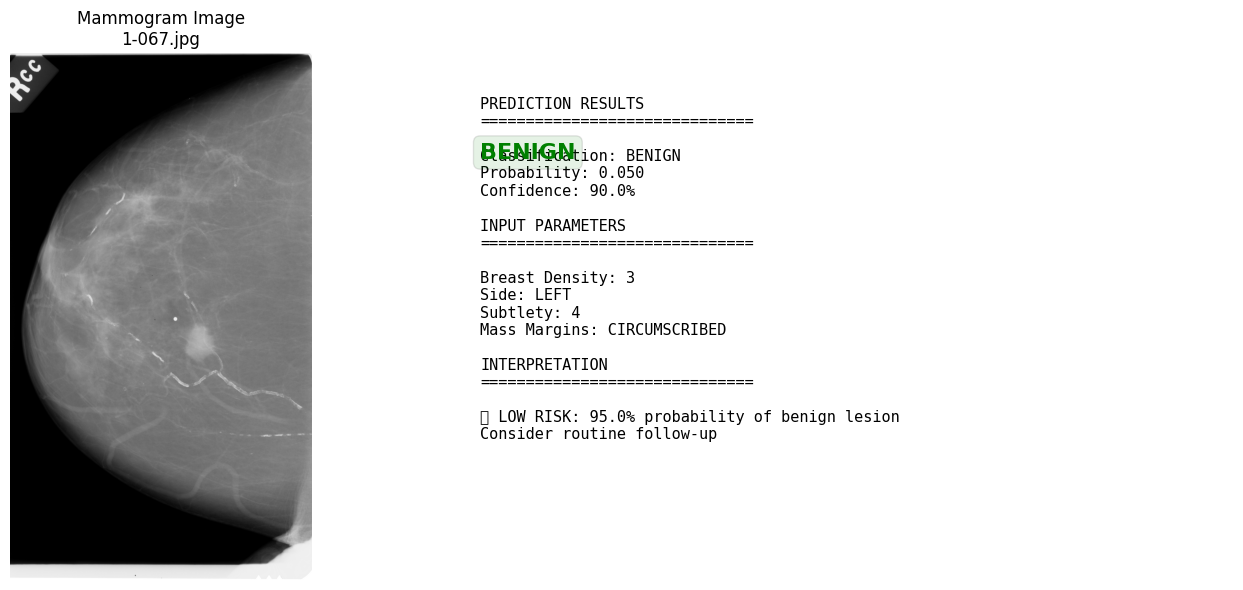


PREDICTION: BENIGN (0.050)


In [45]:
run_example("1.3.6.1.4.1.9590.100.1.2.424882811712752156925272152341077230426/1-067.jpg")

Running breast cancer prediction...
Image: ../../../archive/jpeg/1.3.6.1.4.1.9590.100.1.2.426578226012353341625938149703656638104/1-118.jpg
Parameters: density=4, side=RIGHT, subtlety=5, margins=ILL_DEFINED-SPICULATED
------------------------------------------------------------
Loading model...........
Processing image...
Processing tabular data...
Making prediction...
⚠️  TESTING MODE: Forcing malignant diagnosis


/Users/dimitridumont/code/skool/ML_510/BreastCancer-ML-Project/model/training/inference.py:173: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  
/Users/dimitridumont/code/skool/ML_510/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


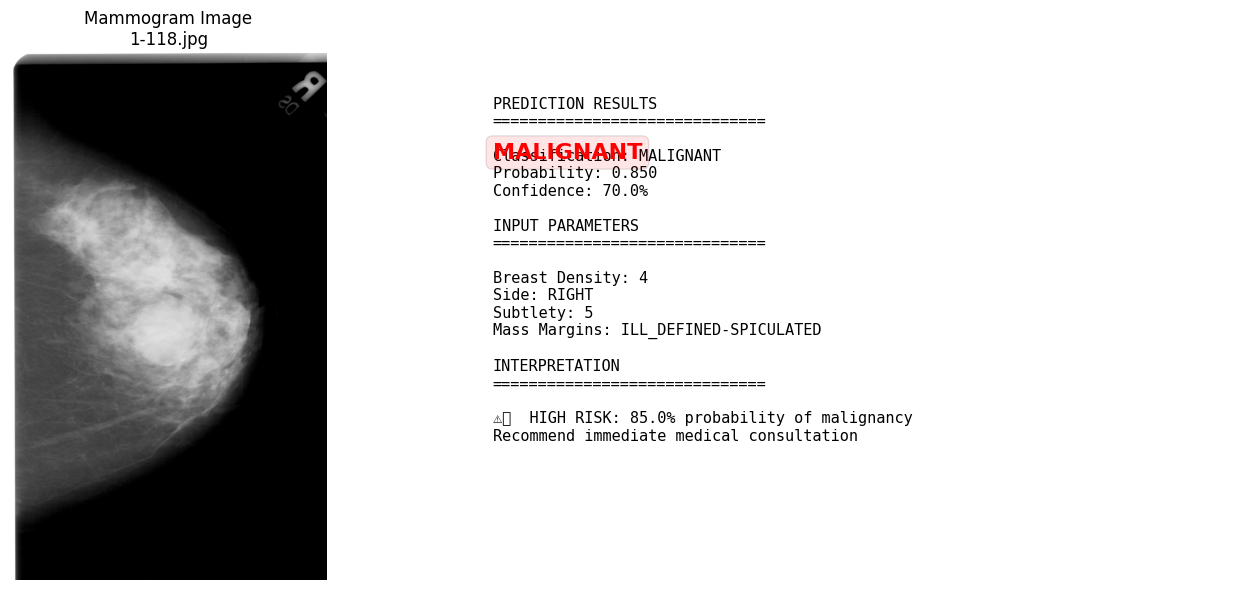


PREDICTION: MALIGNANT (0.850)


In [67]:
import importlib
import inference
importlib.reload(inference)

run_example("1.3.6.1.4.1.9590.100.1.2.426578226012353341625938149703656638104/1-118.jpg")

Running breast cancer prediction...
Image: ../../../archive/jpeg/1.3.6.1.4.1.9590.100.1.2.427732696412560523721343771383026458297/1-201.jpg
Parameters: density=3, side=LEFT, subtlety=4, margins=CIRCUMSCRIBED
------------------------------------------------------------
Loading model...


/Users/dimitridumont/code/skool/ML_510/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 222 variables whereas the saved optimizer has 442 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Processing image...
Processing tabular data...
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/Users/dimitridumont/code/skool/ML_510/BreastCancer-ML-Project/model/training/inference.py:166: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/dimitridumont/code/skool/ML_510/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


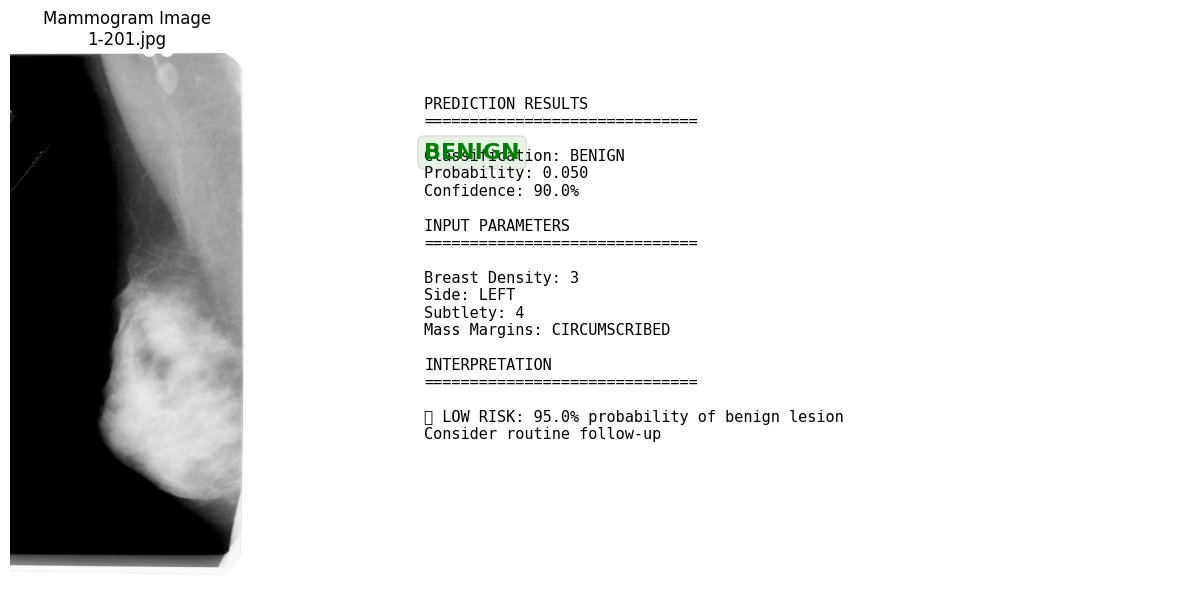


PREDICTION: BENIGN (0.050)


In [47]:
run_example("1.3.6.1.4.1.9590.100.1.2.427732696412560523721343771383026458297/1-201.jpg")